In [21]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import torch.nn.functional as F
from tqdm import tqdm

In [22]:
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!ls drive/MyDrive

'16-831 Project Site.gsite'
'2018 CSSF'
'2019 Synopsys'
'28 SAT Math Lessons to Improve Your Score in One Month - Advanced Course.azw3'
'Acuna entrevista.gdoc'
'Acuna presentation.gdoc'
'AP Cs'
'At Home Lab.gdoc'
'Atwood Pulley Lab.gdoc'
 Barrons_SAT_Subject_Test_Math_Level_1-_4th_Edition.epub
 Barrons_SAT_Subject_Test_Math_Level_2-_10th_Edition.epub
'Board (1).pptx'
 Board.pptx
'Board v2.pptx'
'Boris Johnson Presentation.gslides'
'Boris Johnson Report.gdoc'
'Chardin notes sheet.gdoc'
'Citadel Midwest Datathon'
'Cites for Regeneron Paper.gdoc'
'Colab Notebooks'
'Cold War Suez Crisis.gslides'
'College Spreadsheet.gsheet'
 cs285_f2020
 cs285_f2021
'Custom Neural Network.ipynb'
 drive
'drive MyDrive'
'Essay 3 Study Guide.gdoc'
'Euro Study Guide.gdoc'
'Gary P. Pisano - The development factory_ unlocking the potential of process innovation-Harvard Business Press (1997).epub'
'Gilded Age Trial.gdoc'
'Ground Truth.xlsx'
'Harvard Interview.gdoc'
 hw_16831
'Ian Goodfellow, Yoshua Bengio, Aaron 

In [24]:
# load in addresses of each park 
addresses_df = pd.read_csv('drive/MyDrive/Citadel Midwest Datathon/nyc_parks_bboxes_cehi.csv')
addresses_df = addresses_df.dropna(subset=['cehi'])
img_v2_dataset = []
for filename in tqdm(os.listdir('drive/MyDrive/Citadel Midwest Datathon/city_images_v3')):
    if filename[:2] == 'im':
        img = np.asarray(Image.open('drive/MyDrive/Citadel Midwest Datathon/city_images_v3/' + filename).convert('RGB'))
        img = np.transpose(img, (2, 0, 1))
        img_v2_dataset.append(img)
# get 256 x 256
img_256_dataset = []
for i in range(len(img_v2_dataset)):
    try:
        img = img_v2_dataset[i].copy()
        center_x = len(img[0])//2
        center_y = len(img[0][0])//2
        img = img[:, center_x - 128:center_x + 128, center_y-128:center_y + 128]
        #print(img.shape)
        assert(img.shape[1] == 256 and img.shape[2] == 256)
        img_256_dataset.append((img, i))
    except:
        continue
img_128_dataset = []
for i in range(len(img_v2_dataset)):
    try:
        img = img_v2_dataset[i].copy()
        center_x = len(img[0])//2
        center_y = len(img[0][0])//2
        img = img[:, center_x - 64:center_x + 64, center_y-64:center_y + 64]
        assert(img.shape[1] == 128 and img.shape[2] == 128)
        img_128_dataset.append((img, i))
    except:
        continue

100%|██████████| 1670/1670 [00:22<00:00, 73.28it/s]


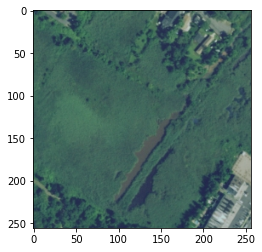

In [25]:
plt.imshow(np.transpose(img_256_dataset[0][0], (1, 2, 0)))

In [26]:
img_256_images = [p[0] for p in img_256_dataset]

In [27]:
img_256_split = []
for i in tqdm(range(len(img_256_images))):
    img = img_256_images[i]
    l = []
    #print(img.shape)
    for i in range(4):
        for j in range(4):
            l.append(img[:, i*64:(i + 1)*64, j*64:(j + 1)*64])
    img_256_split.extend(l)
#     print(img_256_split[0])
#     print("MORE")
#     print(img_256_images[0][:, 0:64, 0:64])
#     assert False
img_256_images = torch.tensor(img_256_images)
img_256_split = torch.tensor(img_256_split)
img_256_split = img_256_split/255.

100%|██████████| 1519/1519 [00:00<00:00, 65848.93it/s]


In [28]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        self.lin1 = nn.Linear(3*64*64, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 512)
        self.lin4 = nn.Linear(512, 3*64*64)
        
    def encode(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return F.sigmoid(x)
    
    def decode(self, x):
        x = F.relu(self.lin3(x))
        return F.sigmoid(self.lin4(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))
    

In [29]:
class ConvAE(nn.Module):
    
    def __init__(self):
        super(ConvAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.elin1 = nn.Linear(1568, 512)
        self.elin2 = nn.Linear(512, 128)
        
        self.dlin1 = nn.Linear(128, 512)
        self.dlin2 = nn.Linear(512, 1568)
        self.unflatten = nn.Unflatten(dim = 1, unflattened_size = (32, 7, 7))
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.dbn1 = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=0, output_padding=1)
        self.dbn2 = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        self.sigm = nn.Sigmoid()
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.flatten(self.conv3(x)))
        x = F.relu(self.elin1(x))
        return self.elin2(x)
    
    def decode(self, x):
        x = F.relu(self.dlin1(x))
        x = F.relu(self.dlin2(x))
        x = F.relu(self.dbn1(self.deconv1(self.unflatten(x))))
        x = F.relu(self.dbn2(self.deconv2(x)))
        return self.deconv3(x)
    
    def forward(self, x):
        return self.sigm(self.decode(self.encode(x)))
        

In [30]:
dataset_split = torch.utils.data.TensorDataset(img_256_split, torch.zeros((len(img_256_split), 1)))
dataloader_split = torch.utils.data.DataLoader(dataset_split, batch_size=64)

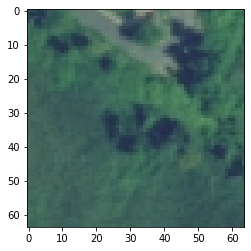

In [31]:
plt.imshow(np.transpose(img_256_split[0].clone().detach().numpy(), (1, 2, 0)))
# working for now

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
ae = ConvAE()
losses = []
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.AdamW(ae.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
for epoch in range(100):
    criterion = torch.nn.MSELoss()
    running_loss = 0
    for (i, data) in tqdm(enumerate(dataloader_split)):
        images, _ = data
        loss = criterion(ae(images), images)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    if epoch % 10 == 0:
      loss /= 2
    # print loss at end 
#     running_loss = 0
#     with torch.no_grad():
#         for (i, data) in tqdm(enumerate(dataloader_split)):
#             images, _ = data
#             loss = criterion(ae(images), torch.flatten(images, start_dim=1))
#             running_loss += loss.item()
    print(f"Running loss at epoch {epoch}: {running_loss}")
    losses.append(running_loss)

380it [00:33, 11.43it/s]


Running loss at epoch 0: 7.098301870748401


380it [00:36, 10.30it/s]


Running loss at epoch 1: 4.51333640050143


380it [00:38,  9.75it/s]


Running loss at epoch 2: 4.012497499585152


380it [00:39,  9.70it/s]


Running loss at epoch 3: 3.7368955314159393


380it [00:38,  9.78it/s]


Running loss at epoch 4: 3.5569054796360433


380it [00:38,  9.94it/s]


Running loss at epoch 5: 3.4399403310380876


380it [00:38,  9.88it/s]


Running loss at epoch 6: 3.3520779544487596


380it [00:39,  9.70it/s]


Running loss at epoch 7: 3.280091242864728


380it [00:38,  9.75it/s]


Running loss at epoch 8: 3.217078763525933


380it [00:37, 10.12it/s]


Running loss at epoch 9: 3.161786150187254


380it [00:38,  9.82it/s]


Running loss at epoch 10: 3.060746031347662


380it [00:39,  9.66it/s]


Running loss at epoch 11: 3.0276484303176403


380it [00:38,  9.94it/s]


Running loss at epoch 12: 3.003254747018218


380it [00:38,  9.90it/s]


Running loss at epoch 13: 2.903392012231052


380it [00:38,  9.78it/s]


Running loss at epoch 14: 2.828849219251424


380it [00:38,  9.77it/s]


Running loss at epoch 15: 2.7826121896505356


380it [00:37, 10.11it/s]


Running loss at epoch 16: 2.7483128923922777


380it [00:39,  9.70it/s]


Running loss at epoch 17: 2.6765684983693063


380it [00:39,  9.73it/s]


Running loss at epoch 18: 2.62480506580323


380it [00:38,  9.83it/s]


Running loss at epoch 19: 2.592155061662197


380it [00:37, 10.11it/s]


Running loss at epoch 20: 2.530375790782273


380it [00:38,  9.76it/s]


Running loss at epoch 21: 2.5143193881958723


380it [00:38,  9.82it/s]


Running loss at epoch 22: 2.5022665755823255


380it [00:37, 10.10it/s]


Running loss at epoch 23: 2.491389516275376


380it [00:39,  9.71it/s]


Running loss at epoch 24: 2.480421971529722


380it [00:38,  9.79it/s]


Running loss at epoch 25: 2.470608477946371


380it [00:38, 10.00it/s]


Running loss at epoch 26: 2.4613140081055462


380it [00:38,  9.87it/s]


Running loss at epoch 27: 2.451678741723299


380it [00:39,  9.69it/s]


Running loss at epoch 28: 2.4430902511812747


380it [00:38,  9.78it/s]


Running loss at epoch 29: 2.4350049402564764


380it [00:37, 10.07it/s]


Running loss at epoch 30: 2.420139157678932


380it [00:38,  9.86it/s]


Running loss at epoch 31: 2.413544257171452


380it [00:38,  9.78it/s]


Running loss at epoch 32: 2.407239868771285


380it [00:38,  9.85it/s]


Running loss at epoch 33: 2.401767149567604


380it [00:38, 10.00it/s]


Running loss at epoch 34: 2.3964580637402833


380it [00:38,  9.75it/s]


Running loss at epoch 35: 2.391380075365305


380it [00:38,  9.81it/s]


Running loss at epoch 36: 2.386330420151353


380it [00:38,  9.80it/s]


Running loss at epoch 37: 2.3814755477942526


380it [00:38,  9.91it/s]


Running loss at epoch 38: 2.3767838897183537


380it [00:38,  9.79it/s]


Running loss at epoch 39: 2.372511750087142


380it [00:39,  9.65it/s]


Running loss at epoch 40: 2.3646170403808355


380it [00:37, 10.02it/s]


Running loss at epoch 41: 2.3614500910043716


380it [00:39,  9.56it/s]


Running loss at epoch 42: 2.3586348560638726


380it [00:38,  9.75it/s]


Running loss at epoch 43: 2.3561064009554684


380it [00:38,  9.86it/s]


Running loss at epoch 44: 2.3537203990854323


380it [00:38,  9.93it/s]


Running loss at epoch 45: 2.351413153577596


380it [00:38,  9.78it/s]


Running loss at epoch 46: 2.3491147398017347


380it [00:38,  9.87it/s]


Running loss at epoch 47: 2.3468976132571697


380it [00:38,  9.85it/s]


Running loss at epoch 48: 2.344724494032562


380it [00:38,  9.82it/s]


Running loss at epoch 49: 2.3425924982875586


380it [00:39,  9.71it/s]


Running loss at epoch 50: 2.336507353466004


380it [00:39,  9.59it/s]


Running loss at epoch 51: 2.3345186901278794


380it [00:38,  9.84it/s]


Running loss at epoch 52: 2.3333312566392124


380it [00:39,  9.60it/s]


Running loss at epoch 53: 2.3321642340160906


380it [00:40,  9.49it/s]


Running loss at epoch 54: 2.330995328258723


380it [00:39,  9.54it/s]


Running loss at epoch 55: 2.329830337781459


380it [00:39,  9.68it/s]


Running loss at epoch 56: 2.328672877047211


380it [00:38,  9.96it/s]


Running loss at epoch 57: 2.3275066767819226


380it [00:38,  9.75it/s]


Running loss at epoch 58: 2.3263555434532464


380it [00:39,  9.66it/s]


Running loss at epoch 59: 2.325213306583464


380it [00:38,  9.99it/s]


Running loss at epoch 60: 2.322319391183555


380it [00:38,  9.92it/s]


Running loss at epoch 61: 2.321482401806861


380it [00:39,  9.73it/s]


Running loss at epoch 62: 2.3208361994475126


380it [00:39,  9.72it/s]


Running loss at epoch 63: 2.320202815812081


380it [00:37, 10.06it/s]


Running loss at epoch 64: 2.3195671630091965


380it [00:38,  9.76it/s]


Running loss at epoch 65: 2.318939301650971


380it [00:38,  9.78it/s]


Running loss at epoch 66: 2.318313226569444


380it [00:38,  9.81it/s]


Running loss at epoch 67: 2.317689497023821


380it [00:38,  9.98it/s]


Running loss at epoch 68: 2.3170657632872462


380it [00:39,  9.73it/s]


Running loss at epoch 69: 2.316437109839171


380it [00:38,  9.80it/s]


Running loss at epoch 70: 2.314521272201091


380it [00:37, 10.05it/s]


Running loss at epoch 71: 2.314083673991263


380it [00:39,  9.68it/s]


Running loss at epoch 72: 2.313730718102306


380it [00:39,  9.73it/s]


Running loss at epoch 73: 2.3133849925361574


380it [00:39,  9.73it/s]


Running loss at epoch 74: 2.313044658396393


380it [00:38,  9.87it/s]


Running loss at epoch 75: 2.3126992927864194


380it [00:39,  9.71it/s]


Running loss at epoch 76: 2.3123573139309883


380it [00:39,  9.67it/s]


Running loss at epoch 77: 2.3120198803953826


380it [00:38,  9.92it/s]


Running loss at epoch 78: 2.3116811509244144


380it [00:38,  9.90it/s]


Running loss at epoch 79: 2.3113389941863716


380it [00:39,  9.73it/s]


Running loss at epoch 80: 2.3101732758805156


380it [00:39,  9.74it/s]


Running loss at epoch 81: 2.309891290497035


380it [00:38,  9.98it/s]


Running loss at epoch 82: 2.3097090967930853


380it [00:39,  9.65it/s]


Running loss at epoch 83: 2.309528619982302


380it [00:39,  9.68it/s]


Running loss at epoch 84: 2.309351318050176


380it [00:39,  9.67it/s]


Running loss at epoch 85: 2.3091736948117614


380it [00:38,  9.98it/s]


Running loss at epoch 86: 2.3089944045059383


380it [00:39,  9.54it/s]


Running loss at epoch 87: 2.308816141448915


380it [00:39,  9.64it/s]


Running loss at epoch 88: 2.3086394774727523


380it [00:40,  9.46it/s]


Running loss at epoch 89: 2.308462163899094


380it [00:39,  9.67it/s]


Running loss at epoch 90: 2.3076980100013316


380it [00:40,  9.42it/s]


Running loss at epoch 91: 2.307557941414416


380it [00:40,  9.44it/s]


Running loss at epoch 92: 2.307466022670269


380it [00:40,  9.47it/s]


Running loss at epoch 93: 2.307375142816454


380it [00:40,  9.31it/s]


Running loss at epoch 94: 2.3072843933478


380it [00:39,  9.65it/s]


Running loss at epoch 95: 2.307193666230887


380it [00:40,  9.31it/s]


Running loss at epoch 96: 2.3071019030176103


380it [00:40,  9.43it/s]


Running loss at epoch 97: 2.307010695338249


380it [00:40,  9.36it/s]


Running loss at epoch 98: 2.3069192618131638


380it [00:42,  8.97it/s]

Running loss at epoch 99: 2.306828571949154


[[[ 97 128 112]
  [ 92 120 108]
  [ 86 109  99]
  ...
  [ 82  99 109]
  [117 131 140]
  [123 140 147]]

 [[ 98 129 111]
  [ 93 121 109]
  [ 96 120 107]
  ...
  [ 66  85  99]
  [ 92 110 122]
  [ 90 108 118]]

 [[102 131 111]
  [ 98 127 109]
  [105 129 113]
  ...
  [ 59  82  96]
  [ 67  89 102]
  [ 64  86  99]]

 ...

 [[108 116 118]
  [138 142 141]
  [136 140 139]
  ...
  [158 168 169]
  [159 171 169]
  [140 152 150]]

 [[106 121 124]
  [125 136 138]
  [122 136 137]
  ...
  [165 170 173]
  [168 177 176]
  [158 167 166]]

 [[100 121 126]
  [100 119 123]
  [103 122 128]
  ...
  [163 167 170]
  [170 175 178]
  [167 173 173]]]
[[[113 131 141]
  [ 93 115 129]
  [ 65  86 103]
  ...
  [189 204 211]
  [188 206 210]
  [185 199 202]]

 [[ 72  92 103]
  [ 64  83  97]
  [ 58  77  91]
  ...
  [180 193 201]
  [174 187 193]
  [170 180 182]]

 [[ 65  85  96]
  [ 74  92 102]
  [ 95 112 119]
  ...
  [150 159 168]
  [145 152 158]
  [146 154 157]]

 ...

 [[132 143 139]
  [138 143 139]
  [145 147 144]
  ..

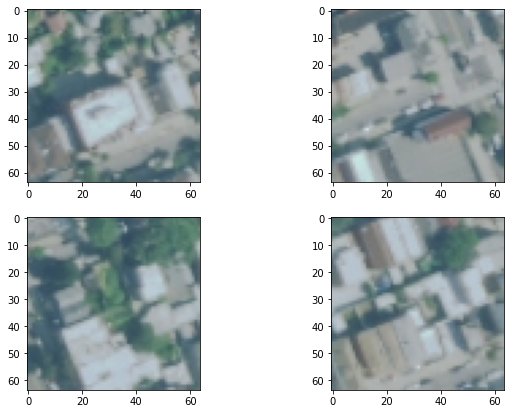

In [ ]:
fig = plt.figure(figsize=(10, 7))
images = [img_256_split[i] for i in range(4)]
for i in range(4):
    images[i] = np.asarray(images[i])
    images[i] = (np.transpose(images[i], (1, 2, 0))*255).astype(int)
    print(images[i])
fig.add_subplot(2, 2, 1)
plt.imshow(images[0])
fig.add_subplot(2, 2, 2)
plt.imshow(images[1])
fig.add_subplot(2, 2, 3)
plt.imshow(images[2])
fig.add_subplot(2, 2, 4)
plt.imshow(images[3])

/var/folders/wr/mqjrrw692kz3x8_2p4trghqr0000gn/T/ipykernel_88371/1665106710.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_n[i] = torch.tensor(images_n[i]).unsqueeze(0)


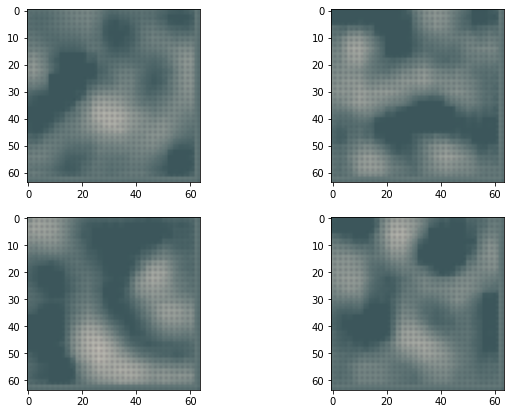

In [ ]:
fig = plt.figure(figsize=(10, 7))
images_n = [img_256_split[i] for i in range(4)]
for i in range(4):
    with torch.no_grad():
        #images_n[i] = np.transpose(images_n[i], (2, 0, 1))
        images_n[i] = torch.tensor(images_n[i]).unsqueeze(0)
        #print(images_n[i].shape)
        images_n[i] = ae(images_n[i]).numpy()[0]
    #print(images_n[i].shape)
    images_n[i] = np.transpose(images_n[i], (1, 2, 0))
    #print(images_n[i].shape)
    images_n[i] = images_n[i]
fig.add_subplot(2, 2, 1)
plt.imshow(images_n[0])
fig.add_subplot(2, 2, 2)
plt.imshow(images_n[1])
fig.add_subplot(2, 2, 3)
plt.imshow(images_n[2])
fig.add_subplot(2, 2, 4)
plt.imshow(images_n[3])

In [ ]:
print(np.linalg.norm(images_n[i]/255. - images[i]/255.)**2)

4218.116994031189


In [ ]:
running_loss = 0
with torch.no_grad():
    for (i, data) in tqdm(enumerate(dataloader_split)):
        images, _ = data
        loss = criterion(ae(images), torch.flatten(images, start_dim=1))
        print(ae(images)[0])
        print(torch.flatten(images, start_dim=1)[0])
        assert False
        running_loss += loss.item()
print(running_loss)

0it [00:00, ?it/s]

tensor([0.4955, 0.5105, 0.5214,  ..., 0.4656, 0.5118, 0.4931])
tensor([0.3804, 0.3608, 0.3373,  ..., 0.6667, 0.6980, 0.6784])


AssertionError: 